# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power", "lowpass_+/-10MHz", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power", "take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 154325,
    "dataset_seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_32', 'O_26', 'O_50', 'O_20', 'O_38', 'O_44', 'O_14', 'O_8'}


{'C_1', 'C_4', 'C_2', 'C_3', 'C_5'}


tensor([[[-0.1931,  0.8758,  0.6037,  ...,  0.7041, -0.3185, -0.0391],
         [-0.4046,  0.2170,  0.5919,  ..., -0.1595,  1.0219,  1.0211]],

        [[ 0.0508,  1.1559,  0.4146,  ...,  0.4908,  0.3583,  0.9554],
         [-0.3878, -0.3983,  0.2625,  ..., -0.2077,  1.1096,  0.3871]],

        [[-0.6662, -0.4533,  0.6746,  ...,  0.4228,  0.8722, -0.3763],
         [-0.4061, -1.1238,  0.1155,  ..., -0.6004, -0.6856, -1.1481]],

        ...,

        [[ 0.1025,  0.7138,  0.1906,  ...,  0.9573,  0.9426,  0.7095],
         [-0.8851, -0.7284,  1.0025,  ...,  0.3112,  0.3567, -0.9834]],

        [[-0.2577,  0.9077,  0.7996,  ...,  0.7522, -0.0283,  0.1294],
         [-0.4825, -0.1084,  0.4870,  ..., -0.4464,  1.0524,  0.9217]],

        [[-0.7522, -1.1439,  0.5260,  ..., -0.3526, -0.3789, -1.2930],
         [ 0.5309,  0.0861, -0.7256,  ..., -0.8873, -0.9504,  0.1101]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 44.7463, train_label_loss: 2.9699, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 1928.2378, train_label_loss: 0.9301, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 1922.7176, train_label_loss: 0.8978, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 1935.9720, train_label_loss: 0.8696, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 1993.2217, train_label_loss: 1.0293, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2465.2805, train_label_loss: 0.9139, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2114.3170, train_label_loss: 1.0257, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 1918.1846, train_label_loss: 0.6385, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 1920.3313, train_label_loss: 0.6848, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 1935.7309, train_label_loss: 0.8392, 


epoch: 1, source_val_acc_label: 0.6460, target_val_acc_label: 0.7300, source_val_label_loss: 1.0137, target_val_label_loss: 1.8988, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.7909, train_label_loss: 0.7411, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 1930.8206, train_label_loss: 0.8854, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 1956.8829, train_label_loss: 1.2405, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 1948.7389, train_label_loss: 0.4687, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2022.7153, train_label_loss: 0.7118, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2477.7570, train_label_loss: 0.6113, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2144.9081, train_label_loss: 0.5554, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 1954.4064, train_label_loss: 0.4036, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 1957.0634, train_label_loss: 1.3250, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 1939.7506, train_label_loss: 0.4451, 


epoch: 2, source_val_acc_label: 0.7501, target_val_acc_label: 0.8048, source_val_label_loss: 0.6788, target_val_label_loss: 1.4737, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.8181, train_label_loss: 0.9989, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 1976.4390, train_label_loss: 0.6385, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 1911.3604, train_label_loss: 1.0593, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 1888.4273, train_label_loss: 0.6856, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 1986.6425, train_label_loss: 0.4146, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2508.9936, train_label_loss: 0.2981, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2122.1185, train_label_loss: 0.8379, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 1935.5198, train_label_loss: 0.4155, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 1921.7874, train_label_loss: 0.2307, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 1912.9416, train_label_loss: 0.7489, 


epoch: 3, source_val_acc_label: 0.7889, target_val_acc_label: 0.8029, source_val_label_loss: 0.5763, target_val_label_loss: 1.6113, 


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8145, train_label_loss: 0.3683, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 1949.3429, train_label_loss: 0.3392, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 1929.6819, train_label_loss: 0.2828, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 1929.8458, train_label_loss: 0.2297, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2006.3208, train_label_loss: 0.4920, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2471.0551, train_label_loss: 0.3836, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2116.0935, train_label_loss: 0.4837, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 1936.3722, train_label_loss: 0.3847, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 1900.8054, train_label_loss: 0.4360, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 1942.8934, train_label_loss: 0.3084, 


epoch: 4, source_val_acc_label: 0.8218, target_val_acc_label: 0.7947, source_val_label_loss: 0.4798, target_val_label_loss: 1.7375, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.8177, train_label_loss: 0.7055, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 1949.6780, train_label_loss: 0.8316, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 1956.9056, train_label_loss: 0.2990, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 1927.6896, train_label_loss: 1.0329, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2018.6776, train_label_loss: 0.4928, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2437.8963, train_label_loss: 0.9824, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2097.8996, train_label_loss: 0.1931, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 1966.9961, train_label_loss: 0.4522, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 1969.1029, train_label_loss: 0.3334, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 1942.0059, train_label_loss: 0.5666, 


epoch: 5, source_val_acc_label: 0.8345, target_val_acc_label: 0.8065, source_val_label_loss: 0.4483, target_val_label_loss: 1.5280, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.8519, train_label_loss: 0.3039, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 1976.2812, train_label_loss: 0.0972, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 1974.1046, train_label_loss: 0.3573, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 1974.6152, train_label_loss: 0.4607, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2044.1328, train_label_loss: 0.3782, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2506.6081, train_label_loss: 0.3539, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2173.3928, train_label_loss: 0.4069, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 1970.2353, train_label_loss: 0.4938, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 1973.1801, train_label_loss: 0.4619, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 1977.6118, train_label_loss: 0.2193, 


epoch: 6, source_val_acc_label: 0.8348, target_val_acc_label: 0.8016, source_val_label_loss: 0.4477, target_val_label_loss: 1.8905, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.8621, train_label_loss: 0.1689, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 1960.3666, train_label_loss: 0.2256, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 1991.6866, train_label_loss: 0.3393, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 1990.4907, train_label_loss: 0.3606, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2061.9129, train_label_loss: 0.0588, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2537.6268, train_label_loss: 0.0908, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2163.1926, train_label_loss: 0.1538, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 1986.6407, train_label_loss: 0.2568, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 1989.4511, train_label_loss: 0.4318, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 1995.4838, train_label_loss: 0.3604, 


epoch: 7, source_val_acc_label: 0.8431, target_val_acc_label: 0.8120, source_val_label_loss: 0.4260, target_val_label_loss: 1.6106, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.8763, train_label_loss: 0.5314, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 1992.3998, train_label_loss: 0.1958, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 1990.8019, train_label_loss: 0.1649, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 1988.9602, train_label_loss: 0.5360, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2079.9958, train_label_loss: 0.4360, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2569.5746, train_label_loss: 0.8584, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2131.6057, train_label_loss: 0.3807, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 1984.9078, train_label_loss: 0.1234, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 1975.4914, train_label_loss: 0.1163, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 1990.1143, train_label_loss: 0.3706, 


epoch: 8, source_val_acc_label: 0.8561, target_val_acc_label: 0.8057, source_val_label_loss: 0.3951, target_val_label_loss: 1.7951, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.8386, train_label_loss: 0.5127, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 1939.3097, train_label_loss: 0.4960, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 1906.0983, train_label_loss: 0.1308, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 1916.2023, train_label_loss: 0.2658, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2035.2669, train_label_loss: 0.3394, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2512.1183, train_label_loss: 0.4870, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2063.0223, train_label_loss: 0.1287, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 1924.8910, train_label_loss: 0.0755, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 1919.6538, train_label_loss: 0.0668, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 1899.3597, train_label_loss: 0.3765, 


epoch: 9, source_val_acc_label: 0.8595, target_val_acc_label: 0.7978, source_val_label_loss: 0.3819, target_val_label_loss: 1.9894, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.7593, train_label_loss: 0.2666, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 1918.3352, train_label_loss: 0.2604, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 1892.2003, train_label_loss: 0.1585, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 1948.7078, train_label_loss: 0.1269, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 1993.2714, train_label_loss: 0.2842, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2425.8430, train_label_loss: 0.2140, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2365.7452, train_label_loss: 0.5941, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2400.4736, train_label_loss: 0.4997, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2369.4470, train_label_loss: 0.1113, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2322.9765, train_label_loss: 0.1245, 


epoch: 10, source_val_acc_label: 0.8663, target_val_acc_label: 0.8020, source_val_label_loss: 0.3643, target_val_label_loss: 1.9659, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.7976, train_label_loss: 0.2546, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3694.2767, train_label_loss: 0.7201, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3721.2276, train_label_loss: 0.2198, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3750.7351, train_label_loss: 0.3598, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3731.2280, train_label_loss: 0.1930, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3787.5951, train_label_loss: 0.4635, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3751.1295, train_label_loss: 0.3678, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2512.1077, train_label_loss: 0.2101, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 1963.4395, train_label_loss: 0.2286, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 1959.3413, train_label_loss: 0.5840, 


epoch: 11, source_val_acc_label: 0.8777, target_val_acc_label: 0.8236, source_val_label_loss: 0.3365, target_val_label_loss: 1.9397, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.8222, train_label_loss: 0.4196, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 1962.9803, train_label_loss: 0.2236, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 1966.1585, train_label_loss: 0.1978, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 1962.4399, train_label_loss: 0.0912, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 1956.3766, train_label_loss: 0.3649, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 1949.1073, train_label_loss: 0.3158, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2408.2871, train_label_loss: 0.0883, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2332.4963, train_label_loss: 0.1789, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 1983.3258, train_label_loss: 0.2805, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 1983.3244, train_label_loss: 0.0586, 


epoch: 12, source_val_acc_label: 0.8784, target_val_acc_label: 0.8141, source_val_label_loss: 0.3345, target_val_label_loss: 1.9060, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.8688, train_label_loss: 0.0777, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 1984.8521, train_label_loss: 0.5118, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 1989.4108, train_label_loss: 0.1339, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 1980.5300, train_label_loss: 0.2671, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 1979.7109, train_label_loss: 0.1848, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 1991.7476, train_label_loss: 0.1871, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2454.2665, train_label_loss: 0.3493, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2320.8175, train_label_loss: 0.1885, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 1984.4751, train_label_loss: 0.2967, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 1983.2881, train_label_loss: 0.2369, 


epoch: 13, source_val_acc_label: 0.8782, target_val_acc_label: 0.8057, source_val_label_loss: 0.3413, target_val_label_loss: 2.1540, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.8723, train_label_loss: 0.2046, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 1984.6801, train_label_loss: 0.1272, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 1989.4353, train_label_loss: 0.6148, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 1983.6638, train_label_loss: 0.2689, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 1980.8084, train_label_loss: 0.1985, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2000.2107, train_label_loss: 0.1293, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2436.8053, train_label_loss: 0.0831, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2309.5637, train_label_loss: 0.1876, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 1984.0894, train_label_loss: 0.0908, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 1983.8467, train_label_loss: 0.1165, 


epoch: 14, source_val_acc_label: 0.8823, target_val_acc_label: 0.8025, source_val_label_loss: 0.3309, target_val_label_loss: 2.2070, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.8708, train_label_loss: 0.3401, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 1986.8872, train_label_loss: 0.2252, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 1988.4516, train_label_loss: 0.1385, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 1985.8748, train_label_loss: 0.3308, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 1980.9386, train_label_loss: 0.0447, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2012.7218, train_label_loss: 0.1733, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2448.2394, train_label_loss: 0.3000, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2288.6924, train_label_loss: 0.2870, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 1983.3428, train_label_loss: 0.0958, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 1984.7032, train_label_loss: 0.1634, 


epoch: 15, source_val_acc_label: 0.8678, target_val_acc_label: 0.8095, source_val_label_loss: 0.3789, target_val_label_loss: 2.2963, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

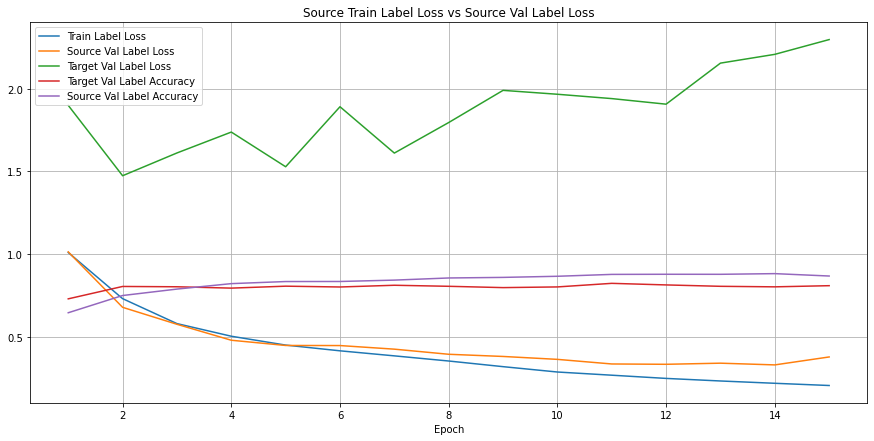

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

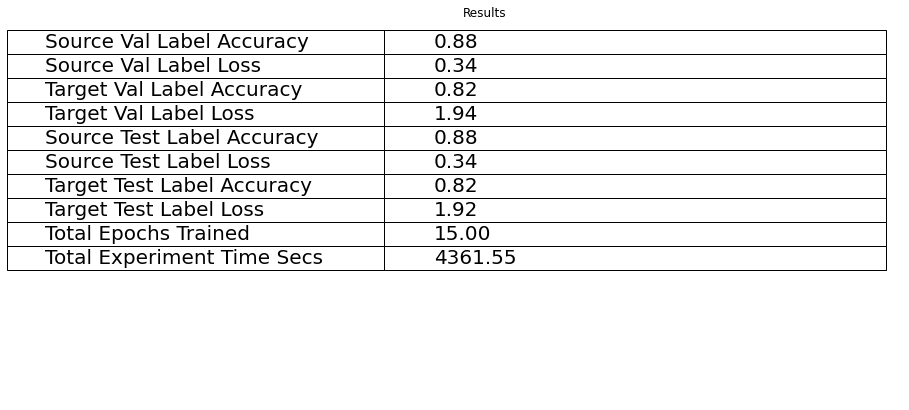

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

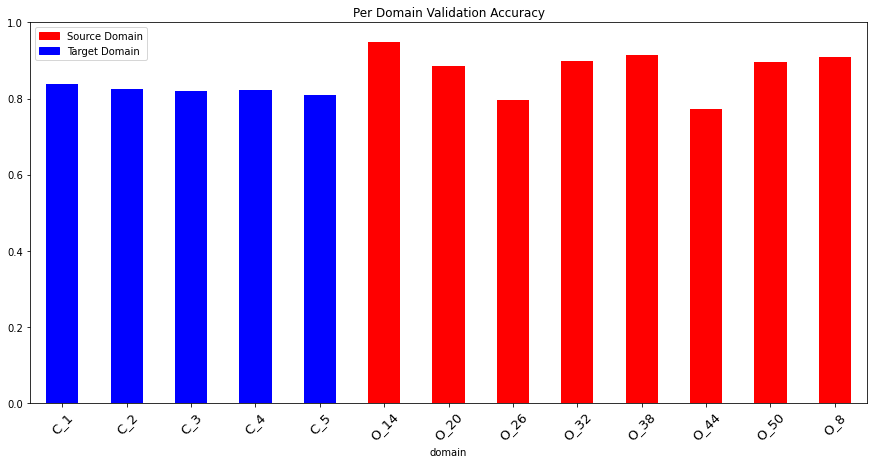

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.879296875 Target Test Label Accuracy: 0.8200937849944009
Source Val Label Accuracy: 0.8776692708333333 Target Val Label Accuracy: 0.8235840961098398


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "parameters": {"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "device": "cuda", "lr": 0.0001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_